In [32]:
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, Draw
import pandas as pd
import numpy as np
import requests

In [29]:
compound_names = ["aspirin", "caffeine", "ibuprofen", "morphine"]
data = []

for name in compound_names:

    url_cid = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{name}/cids/JSON"
    resp_cid = requests.get(url_cid).json()
    cids = resp_cid.get("IdentifierList", {}).get("CID", [])
    if not cids:
        print(f"No CID found for {name}")
        continue
    cid = cids[0]

Step 1. Define a list of molecules with verified SMILES.
This ensures reproducibility without relying on online APIs

In [34]:
molecules = [
    {"Name": "Aspirin", "SMILES": "CC(=O)OC1=CC=CC=C1C(=O)O"},
    {"Name": "Caffeine", "SMILES": "Cn1cnc2c1c(=O)n(c(=O)n2C)C"},
    {"Name": "Ibuprofen", "SMILES": "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O"},
    {"Name": "Morphine", "SMILES": "CN1CCC23C4=CC=CC=C4O[C@H]2[C@H](O)C=C[C@H]3O1"},
    {"Name": "Paracetamol", "SMILES": "CC(=O)NC1=CC=C(C=C1)O"},
    {"Name": "Penicillin G", "SMILES": "CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](C3=CC=CC=C3)N)C(=O)N2C1=O"},
    {"Name": "Chloroquine", "SMILES": "CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12"},
    {"Name": "Diazepam", "SMILES": "CN1C(=O)CN=C(c2ccccc2)c2ccccc21"},
    {"Name": "Lidocaine", "SMILES": "CCN(CC)C(=O)C1=CC=CC=C1"},
    {"Name": "Warfarin", "SMILES": "CC(=O)C(C1=CC=CC=C1)C(=O)OCC2=CC=CC=C2"}
]

Step 2.  Compute descriptors and Lipinski Rule.
 - Calculate molecular descriptors and Lipinski Rule of Five
 - MolWt, LogP, HBD (H-bond donors), HBA (H-bond acceptors)
 - Lipinski rule: MolWt <= 500, LogP <= 5, HBD <= 5, HBA <= 10

In [35]:
data = []

for mol_info in molecules:
    smiles = mol_info["SMILES"]
    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        print(f"Failed to parse SMILES for {mol_info['Name']}: {smiles}")
        continue

    molwt = Descriptors.MolWt(mol)
    logp = Descriptors.MolLogP(mol)
    hbd = Descriptors.NumHDonors(mol)
    hba = Descriptors.NumHAcceptors(mol)

    lipinski = (molwt <= 500) and (logp <= 5) and (hbd <= 5) and (hba <= 10)

    data.append({
        "Name": mol_info["Name"],
        "SMILES": smiles,
        "MolWt": molwt,
        "LogP": logp,
        "HBD": hbd,
        "HBA": hba,
        "Lipinski": lipinski,
        "MolObject": mol
    })

df = pd.DataFrame(data)
df

,Name,SMILES,MolWt,LogP,HBD,HBA,Lipinski,MolObject
0,Aspirin,CC(=O)OC1=CC=CC=C1C(=O)O,180.159,1.3101,1,3,True,<rdkit.Chem.rdchem.Mol object at 0x11f8953f0>
1,Caffeine,Cn1cnc2c1c(=O)n(c(=O)n2C)C,194.194,-1.0293,0,6,True,<rdkit.Chem.rdchem.Mol object at 0x11f895770>
2,Ibuprofen,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,206.285,3.0732,1,1,True,<rdkit.Chem.rdchem.Mol object at 0x11f803530>
3,Morphine,CN1CCC23C4=CC=CC=C4O[C@H]2[C@H](O)C=C[C@H]3O1,259.305,1.2518,1,4,True,<rdkit.Chem.rdchem.Mol object at 0x11f8035a0>
4,Paracetamol,CC(=O)NC1=CC=C(C=C1)O,151.165,1.3506,2,2,True,<rdkit.Chem.rdchem.Mol object at 0x11f803680>
5,Penicillin G,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](C3=CC=CC=C3)N)...,319.386,0.3915,2,5,True,<rdkit.Chem.rdchem.Mol object at 0x11f801000>
6,Chloroquine,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,319.880,4.8106,1,3,True,<rdkit.Chem.rdchem.Mol object at 0x11f801310>
7,Diazepam,CN1C(=O)CN=C(c2ccccc2)c2ccccc21,250.301,2.5004,0,2,True,<rdkit.Chem.rdchem.Mol object at 0x11f801150>
8,Lidocaine,CCN(CC)C(=O)C1=CC=CC=C1,177.247,2.1686,0,1,True,<rdkit.Chem.rdchem.Mol object at 0x11f801230>
9,Warfarin,CC(=O)C(C1=CC=CC=C1)C(=O)OCC2=CC=CC=C2,268.312,3.1026,0,3,True,<rdkit.Chem.rdchem.Mol object at 0x11f8013f0>


Step 3. Visualize molecules in a grid.
 - This shows all molecules in a single image

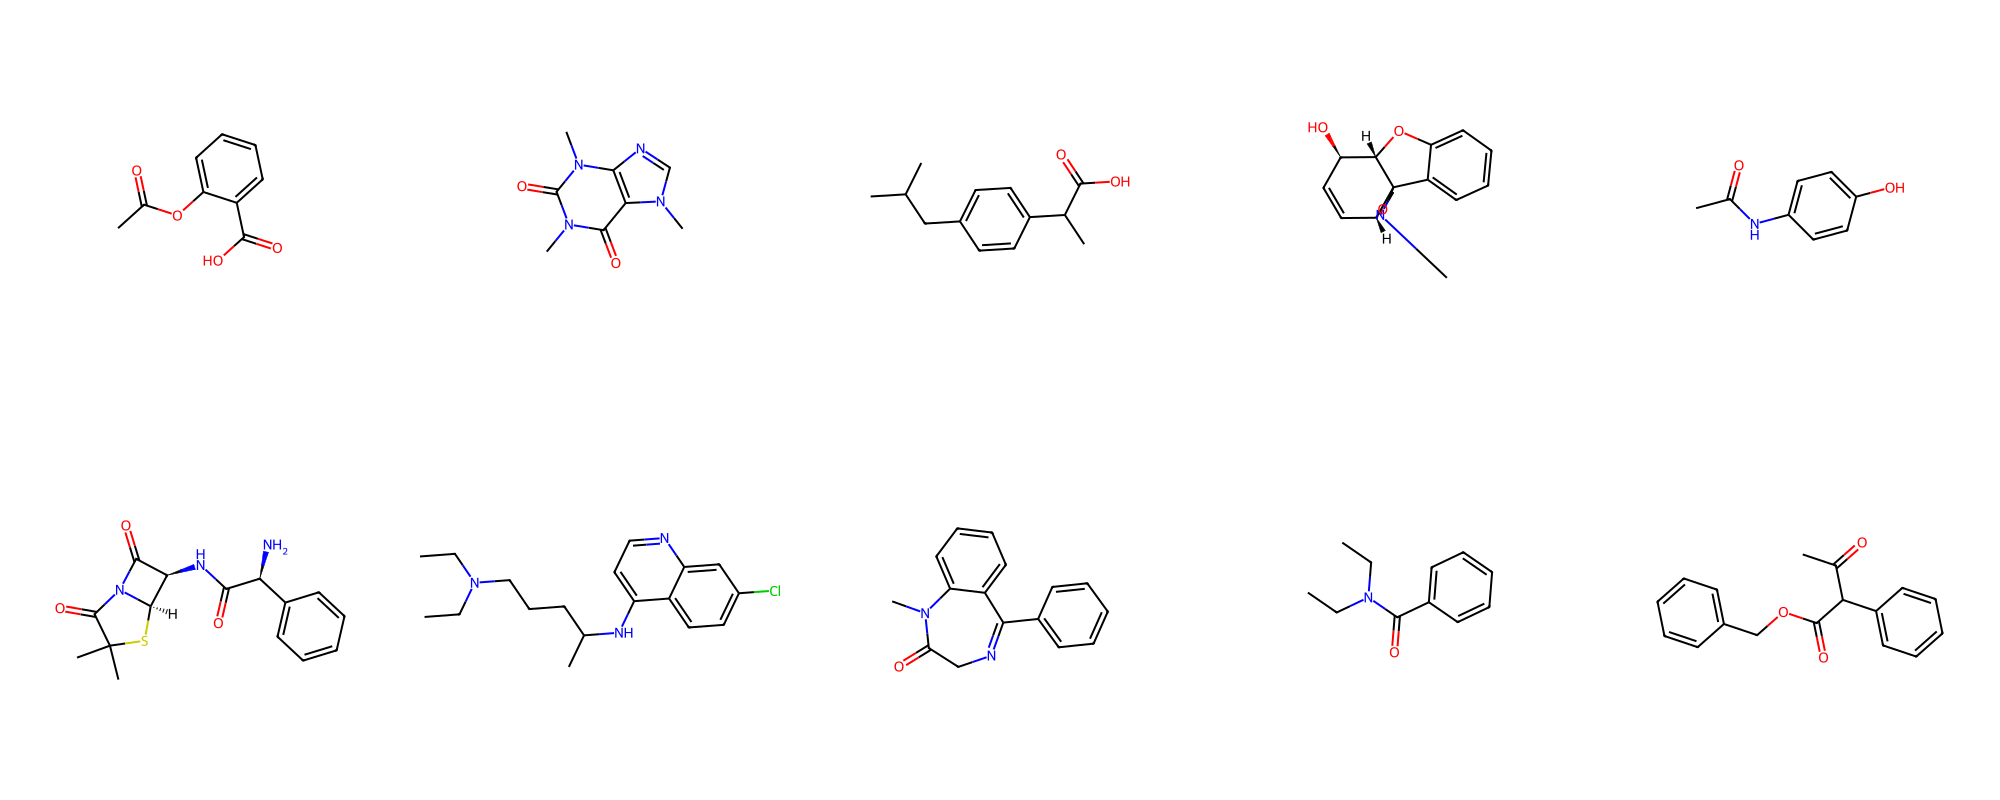

In [38]:
mol_list = df["MolObject"].tolist()  # get list of RDKit Mol objects
Draw.MolsToGridImage(mol_list, molsPerRow=5, subImgSize=(400,400))

Step 4.  Generate Morgan fingerprints.
 - Generate Morgan fingerprints for ML / similarity analysis: radius=2, nBits=1024 is standard for cheminformatics

In [41]:
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator

In [43]:
# Create Morgan fingerprint generator
morgan_gen = GetMorganGenerator(radius=2, fpSize=1024)

df["Fingerprint"] = df["MolObject"].apply(
    lambda m: morgan_gen.GetFingerprint(m)
)
df

,Name,SMILES,MolWt,LogP,HBD,HBA,Lipinski,MolObject,Fingerprint
0,Aspirin,CC(=O)OC1=CC=CC=C1C(=O)O,180.159,1.3101,1,3,True,<rdkit.Chem.rdchem.Mol object at 0x11f8953f0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
1,Caffeine,Cn1cnc2c1c(=O)n(c(=O)n2C)C,194.194,-1.0293,0,6,True,<rdkit.Chem.rdchem.Mol object at 0x11f895770>,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Ibuprofen,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,206.285,3.0732,1,1,True,<rdkit.Chem.rdchem.Mol object at 0x11f803530>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Morphine,CN1CCC23C4=CC=CC=C4O[C@H]2[C@H](O)C=C[C@H]3O1,259.305,1.2518,1,4,True,<rdkit.Chem.rdchem.Mol object at 0x11f8035a0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Paracetamol,CC(=O)NC1=CC=C(C=C1)O,151.165,1.3506,2,2,True,<rdkit.Chem.rdchem.Mol object at 0x11f803680>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,Penicillin G,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](C3=CC=CC=C3)N)...,319.386,0.3915,2,5,True,<rdkit.Chem.rdchem.Mol object at 0x11f801000>,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,Chloroquine,CCN(CC)CCCC(C)Nc1ccnc2cc(Cl)ccc12,319.880,4.8106,1,3,True,<rdkit.Chem.rdchem.Mol object at 0x11f801310>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,Diazepam,CN1C(=O)CN=C(c2ccccc2)c2ccccc21,250.301,2.5004,0,2,True,<rdkit.Chem.rdchem.Mol object at 0x11f801150>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,Lidocaine,CCN(CC)C(=O)C1=CC=CC=C1,177.247,2.1686,0,1,True,<rdkit.Chem.rdchem.Mol object at 0x11f801230>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,Warfarin,CC(=O)C(C1=CC=CC=C1)C(=O)OCC2=CC=CC=C2,268.312,3.1026,0,3,True,<rdkit.Chem.rdchem.Mol object at 0x11f8013f0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
